## Packages

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from warnings import filterwarnings
from pprint import pprint
filterwarnings("ignore")
%matplotlib inline

## Global Parameters

In [2]:
ROOT_DIRECTORY = "/home/kaan.aytekin/Thesis"
#ROOT_DIRECTORY = "/Users/kaan.aytekin/Desktop/Kaan/Thesis"
SIMULATION_DURATION = 90 * 60 #Seconds
WARM_UP_PERIOD_DURATION = 15 * 60 #Seconds
COOL_DOWN_PERIOD_DURATION = 15 * 60 #Seconds
DETECTOR_SEPARATION_DISTANCE = 500 #Meter
DETECTOR_COUNT = 21
TOTAL_ROAD_LENGTH = DETECTOR_COUNT * DETECTOR_SEPARATION_DISTANCE

## UDFs

In [3]:
def timeit(func):
    """Wrapper function for logging the function duration

    Args:
        func (function): Function to measure performance

    Returns:
        function: Function with performance measurement capabilities
    """
    from functools import wraps
    import datetime as dt
    @wraps(func)
    def timed(*args, **kwargs):
        function_name = func.__name__
        start_time = dt.datetime.now()
        result = func(*args, **kwargs)
        end_time = dt.datetime.now()
        execution_duration = (end_time - start_time).total_seconds()
        print(
            f"Function {function_name!r} executed in {execution_duration:.4f} seconds ({execution_duration/60:.2f} minutes)")
        return result
    return timed

def calculate_section_travel_time(speed_kilometer_per_second):
    speed_meter_per_second = speed_kilometer_per_second * (1000 / (60 * 60))
    if speed_meter_per_second:
        travel_time_sec = DETECTOR_SEPARATION_DISTANCE / speed_meter_per_second
        return travel_time_sec

def calculate_time_after_accident_start(df_row):
    if df_row.is_accident_timestamp:
        return float(df_row.timestamp - df_row.accident_start_time)
    else:
        return 0

def calculate_distance_to_accident(df_row):
    if df_row.is_accident_timestamp:
        return float(
            df_row.accident_location
            - df_row.detector_number * DETECTOR_SEPARATION_DISTANCE
        )
    else:
        return 9999999#np.Inf

@timeit
def calculate_detector_lag_values(df, max_lag=10):
    simulation_config_columns = [
        "simulation_run",
        "connected_vehicle_ratio",
        "accident_location",
        "accident_start_time",
        "accident_duration",
        "accident_lane",
        "detector_number",
    ]
    traffic_metrics = [
        "flow_vehph",
        "density_vehpkm",
        "avg_speed_kmph",
        "section_travel_time_sec",
        "delay_time_sec",
    ]
    df_sorted = df.sort_values(simulation_config_columns + ["timestamp"])
    for lag_number in range(max_lag):
        lag_number += 1
        lagged_features = [
            f"flow_vehph_lag{lag_number}",
            f"density_vehpkm_lag{lag_number}",
            f"avg_speed_kmph_lag{lag_number}",
            f"section_travel_time_sec_lag{lag_number}",
            f"delay_time_sec_lag{lag_number}",
        ]
        df_sorted[lagged_features] = df_sorted.groupby(by=simulation_config_columns)[
            traffic_metrics
        ].shift(lag_number)
    return df_sorted


@timeit
def calculate_adjacent_detector_features(df):
    def key_mapper(key):
        if "_next_detector" in key:
            new_key = key.replace("_next_detector", "")
            new_key = "next_detector_" + new_key
        elif "_prev_detector" in key:
            new_key = key.replace("_prev_detector", "")
            new_key = "prev_detector_" + new_key
        else:
            new_key = key
        return new_key

    merging_columns = [
        "simulation_run",
        "connected_vehicle_ratio",
        "accident_location",
        "accident_start_time",
        "accident_duration",
        "accident_lane",
        "timestamp",
        "detector_number",
    ]
    simulation_metrics = [
        "flow_vehph",
        "density_vehpkm",
        "avg_speed_kmph",
        "section_travel_time_sec",
        "delay_time_sec",
    ]
    simulation_metrics_with_lags = simulation_metrics.copy()
    max_lag = 10
    for lag_number in range(max_lag):
        lag_number += 1
        simulation_metrics_with_lags = simulation_metrics_with_lags + [
            f"{metric}_lag{lag_number}" for metric in simulation_metrics
        ]

    df["next_detector_number"] = df["detector_number"] + 1
    df["prev_detector_number"] = df["detector_number"] - 1

    df_merged = df.merge(
        df[merging_columns + simulation_metrics_with_lags],
        how="left",
        left_on=merging_columns[:-1] + ["next_detector_number"],
        right_on=merging_columns,
        suffixes=("", "_next_detector"),
    )
    df_merged = df_merged.merge(
        df[merging_columns + simulation_metrics_with_lags],
        how="left",
        left_on=merging_columns[:-1] + ["prev_detector_number"],
        right_on=merging_columns,
        suffixes=("", "_prev_detector"),
    )
    df_merged = df_merged.drop(["next_detector_number", "prev_detector_number"], axis=1)

    df_merged = df_merged.rename(columns=key_mapper)
    return df_merged

@timeit
def calculate_target_value(df):
    simulation_config_columns = [
        "simulation_run",
        "connected_vehicle_ratio",
        "accident_location",
        "accident_start_time",
        "accident_duration",
        "accident_lane",
        "detector_number",
    ]
    df_sorted = df.sort_values(simulation_config_columns + ["timestamp"])
    target_delay_time = df_sorted.groupby(by=simulation_config_columns)[
        "delay_time_sec"
    ].shift(-1)
    return target_delay_time

@timeit
def plot_detector_timelines(df, detector_metric, detector_numbers, simulation_configs):
    detector_metric_name_map = {
        "flow_vehph": "Flow(Veh/Hr)",
        "density_vehpkm": "Density(Veh/Km)",
        "avg_speed_kmph": "Speed(Km/Hr)",
        "section_travel_time_sec": "Travel Time(Sec)",
        "delay_time_sec": "Delay Time(Sec)",
    }
    detector_metric_name = detector_metric_name_map[detector_metric]
    # Data Filtering
    simulation_selector = None
    for key, value in simulation_configs.items():
        if simulation_selector is not None:
            simulation_selector = (simulation_selector) & (df[key] == value)
        else:
            simulation_selector = df[key] == value
    detector_selector = None
    for detector in detector_numbers:
        if detector_selector is not None:
            detector_selector = (detector_selector) | (
                df["detector_number"] == detector
            )
        else:
            detector_selector = df["detector_number"] == detector
    plotting_columns = {
        "x": "timestamp",
        "y": detector_metric,
        "hue": "detector_number",
        # "style":"detector_number"
    }
    plotting_df = df[simulation_selector & detector_selector][
        list(set(plotting_columns.values()))
    ]
    # Plotting helpers
    max_metric_point = plotting_df[detector_metric].max()
    detector_numbers_str = f"{detector_numbers}".strip("[]")
    accident_start_time = simulation_configs["accident_start_time"]
    accident_duration = simulation_configs["accident_duration"]
    accident_detector = int(
        np.ceil(simulation_configs["accident_location"] / DETECTOR_SEPARATION_DISTANCE)
    )
    title = f"{detector_metric_name.split('(')[0]} distribution for Detector(s) {detector_numbers_str}\n Accident Configs: {simulation_configs}\nAccident in detector {accident_detector}"
    # Plotting
    figure(num=None, figsize=(20, 12), dpi=80, facecolor="w", edgecolor="k")
    # ax = sns.lineplot(data=plotting_df,palette=sns.color_palette("Spectral",len(detector_numbers)),**plotting_columns)
    ax = sns.lineplot(
        data=plotting_df,
        palette=sns.color_palette("husl", len(detector_numbers)),
        **plotting_columns,
    )
    ax.set(title=title, xlabel="Timestamp(sec)", ylabel=detector_metric_name)
    plt.vlines(
        x=accident_start_time,
        ymin=0,
        ymax=max_metric_point,
        colors="blue",
        linewidths=3,
    )
    plt.vlines(
        x=accident_start_time + accident_duration,
        ymin=0,
        ymax=max_metric_point,
        colors="blue",
        linewidths=3,
    )
    plt.show()

## Data Preperations

In [4]:

#aggreagated_data_path = os.path.join(ROOT_DIRECTORY,"data/thesis_data/aggreagated_simulation_data.csv")
aggreagated_data_path = os.path.join(ROOT_DIRECTORY,"data/thesis_data/aggreagated_simulation_data_merged.csv")
complete_df = pd.read_csv(aggreagated_data_path)
#Rename columns
complete_df = complete_df.rename(columns = {
    "avg_speed":"avg_speed_kmph",
    "density": "density_vehpkm",
    "flow": "flow_vehph"
}
)
#Calculate avg. travel times between detectors based on the detector separation distance and avg. speed
complete_df["section_travel_time_sec"] = complete_df["avg_speed_kmph"].apply(calculate_section_travel_time)

#Remove accident simulations & warm-up & cool-down periods to get free flow speed
no_accident_warm_up_df = complete_df[
    (WARM_UP_PERIOD_DURATION < complete_df.timestamp) #First 15 minutes
    & (complete_df.timestamp < SIMULATION_DURATION - COOL_DOWN_PERIOD_DURATION) #Last 15 minutes
    & (complete_df.accident_duration==0)
    & (~complete_df.section_travel_time_sec.isna())
]
freeflow_section_travel_time_sec = no_accident_warm_up_df["section_travel_time_sec"].min()

complete_df["delay_time_sec"] = complete_df["section_travel_time_sec"] - freeflow_section_travel_time_sec

#Remove warm-up periods
df = complete_df[
    (WARM_UP_PERIOD_DURATION < complete_df.timestamp) #First 15 minutes
    & (complete_df.timestamp < SIMULATION_DURATION - COOL_DOWN_PERIOD_DURATION) #Last 15 minutes
]
df = df.reset_index(drop=True)

In [6]:
simulation_configs = {
    "is_accident_simulation" : 1,
    #"connected_vehicle_ratio" : 0.6,
    "accident_location" : 6636,
    "accident_start_time" : 2234,
    "accident_duration" : 1492,
    "accident_lane" : 1,
    #"detector_number" : 14
}
local_incident_data = df[
    (df.is_accident_simulation == 1)
    & (df.accident_location == 6636)
    & (df.accident_start_time == 2234)
    & (df.accident_duration == 1492)
    & (df.accident_lane == 1)
]
local_incident_data.groupby(["connected_vehicle_ratio"])["flow_vehph","density_vehpkm","avg_speed_kmph","section_travel_time_sec","delay_time_sec"].mean().to_csv()

'connected_vehicle_ratio,flow_vehph,density_vehpkm,avg_speed_kmph,section_travel_time_sec,delay_time_sec\n0.0,1382.219565650528,11.779965324314148,65.99966780181352,30.89789093928152,13.656511628936594\n0.1,1399.5138473799561,11.42821254388602,68.93614699904576,29.383356302397374,12.141976992052506\n0.2,1395.5768081291094,11.826747799356246,69.6324189816958,30.42095931909531,13.179580008750353\n0.3,1403.1639768878263,10.895027467053763,73.29714594232232,27.134287288484263,9.892907978139304\n0.4,1404.5507073122135,12.373267298551202,72.83849221310655,49.23242690671019,31.991047596365185\n0.5,1425.9254831639769,9.472185818114767,80.87094978343046,23.27284905985948,6.031469749514619\n0.6,1408.9340506076908,9.426241153183124,83.36740024669476,23.29657958224635,6.055200271901453\n0.7,1427.822275353656,9.757341976266606,84.87103892322047,23.516080510603373,6.274701200258432\n0.8,1413.9390316796175,9.049783493532017,87.17473358679588,22.197838052213598,4.956458741868702\n'

In [5]:
df.head()

,simulation_run,is_accident_simulation,connected_vehicle_ratio,accident_location,accident_start_time,accident_duration,accident_lane,timestamp,is_accident_timestamp,detector_number,flow_vehph,density_vehpkm,avg_speed_kmph,section_travel_time_sec,delay_time_sec
0,58,0,0.0,0,0,0,0,915,0,1,1360.0,13.316770,49.090909,36.666667,19.425287
1,58,0,0.0,0,0,0,0,915,0,2,400.0,1.111801,103.680000,17.361111,0.119732
2,58,0,0.0,0,0,0,0,915,0,3,1440.0,10.683230,58.500000,30.769231,13.527851
3,58,0,0.0,0,0,0,0,915,0,4,1520.0,10.111801,64.800000,27.777778,10.536398
4,58,0,0.0,0,0,0,0,915,0,5,1680.0,10.993789,78.428571,22.950820,5.709440


## Natural Mean Delay Distribution Plot

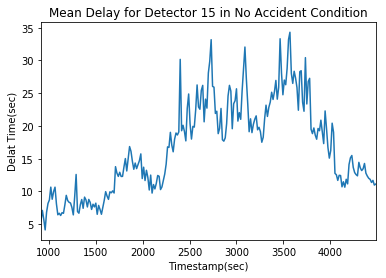

In [6]:
#Check mean delay for NO_ACCIDENT-DECETOR_15
ax = df[
    (df.accident_location == 0)
    & (df.detector_number == 15)
].groupby("timestamp")["delay_time_sec"].mean().plot()
ax.set(title="Mean Delay for Detector 15 in No Accident Condition",xlabel='Timestamp(sec)', ylabel='Delat Time(sec)')
plt.show()

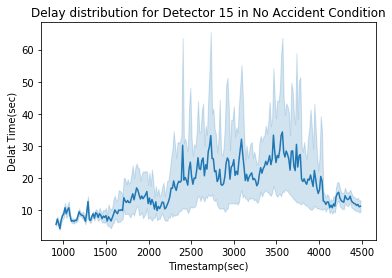

In [7]:
#Check mean delay distribution for NO_ACCIDENT-DECETOR_15
plotting_df = df[
    (df.accident_location == 0)
    & (df.detector_number == 15)
][["timestamp","delay_time_sec"]]
ax = sns.lineplot(data=plotting_df,x="timestamp",y="delay_time_sec")
ax.set(title="Delay distribution for Detector 15 in No Accident Condition",xlabel='Timestamp(sec)', ylabel='Delat Time(sec)')
plt.show()

### Accident Simulation Plot

In [9]:
df[
    (df.is_accident_simulation == 1)
    & (df.accident_lane == 3)
][
    [
    "is_accident_simulation",
    "connected_vehicle_ratio",
    "accident_location",
    "accident_start_time",
    "accident_duration",
    "accident_lane",]
].drop_duplicates()

,is_accident_simulation,connected_vehicle_ratio,accident_location,accident_start_time,accident_duration,accident_lane
105399,1,0.0,6504,1613,827,3
155589,1,0.0,7764,1384,999,3
175665,1,0.0,7290,1076,674,3
200760,1,0.0,7597,1444,1391,3
210798,1,0.0,5078,1291,1328,3
225855,1,0.0,7861,2404,709,3
245931,1,0.0,5794,2359,1460,3
250950,1,0.0,6108,1427,1093,3
326235,1,0.0,5001,1248,1238,3
331254,1,0.0,7057,2295,836,3


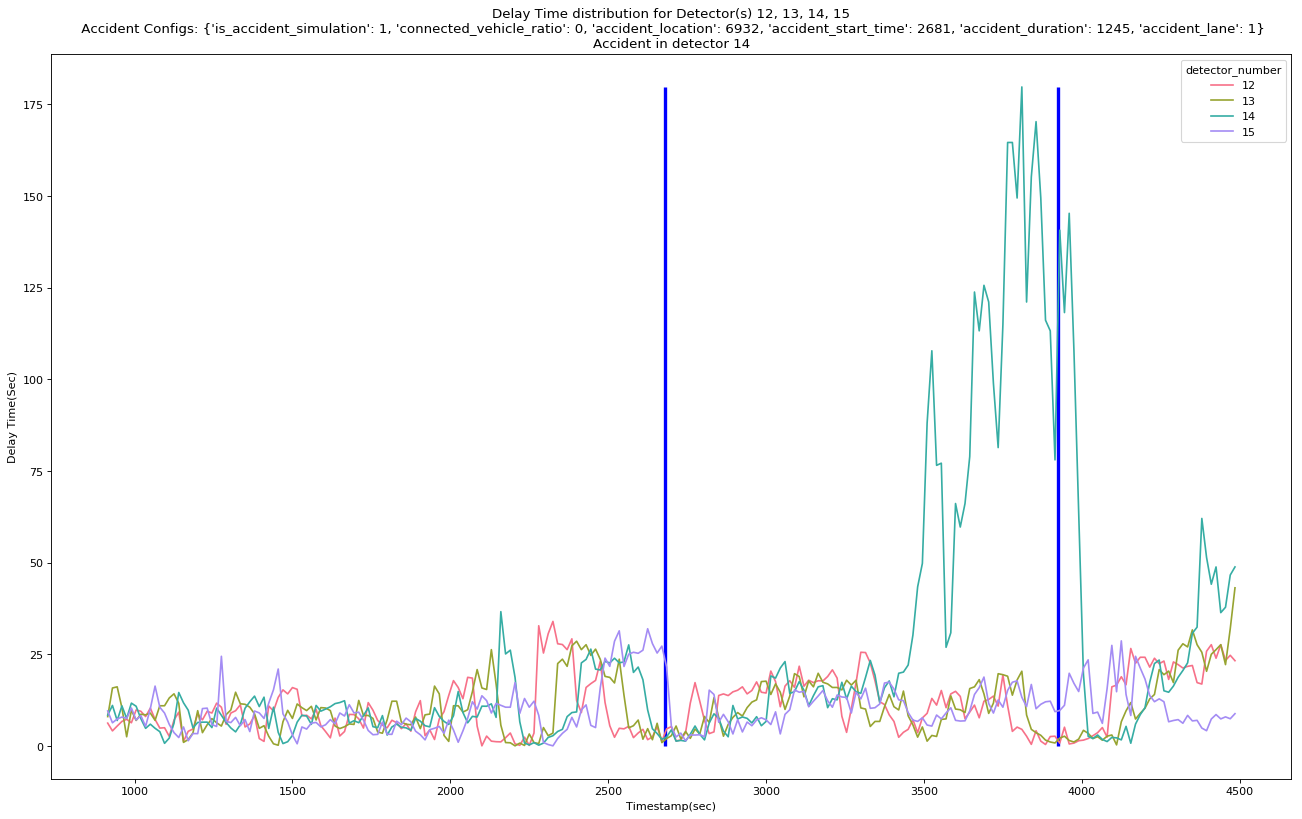

Function 'plot_detector_timelines' executed in 0.6455 seconds (0.01 minutes)


In [10]:
simulation_configs = {
    "is_accident_simulation" : 1,
    "connected_vehicle_ratio": 0,
    "accident_location" : 6932,
    "accident_start_time" : 2681,
    "accident_duration" : 1245,
    "accident_lane" : 1,
}
detector_numbers = [12,13,14,15]
plot_detector_timelines(df=df,detector_metric="delay_time_sec",detector_numbers=detector_numbers,simulation_configs=simulation_configs)

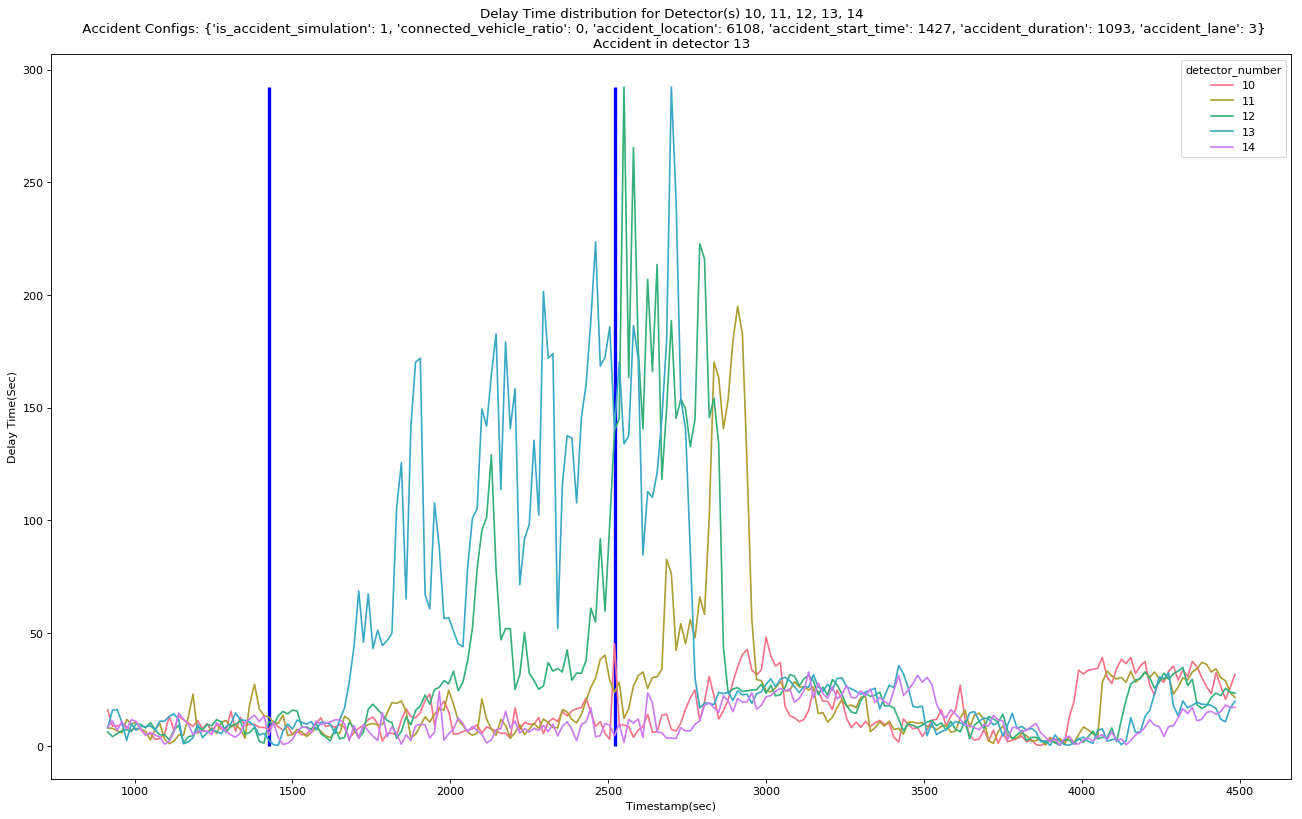

Function 'plot_detector_timelines' executed in 0.7217 seconds (0.01 minutes)


In [11]:
simulation_configs = {
    "is_accident_simulation" : 1,
    "connected_vehicle_ratio": 0,
    "accident_location" : 6108,
    "accident_start_time" : 1427,
    "accident_duration" : 1093,
    "accident_lane" : 3,
}
detector_numbers = [10,11,12,13,14]
plot_detector_timelines(df=df,detector_metric="delay_time_sec",detector_numbers=detector_numbers,simulation_configs=simulation_configs)


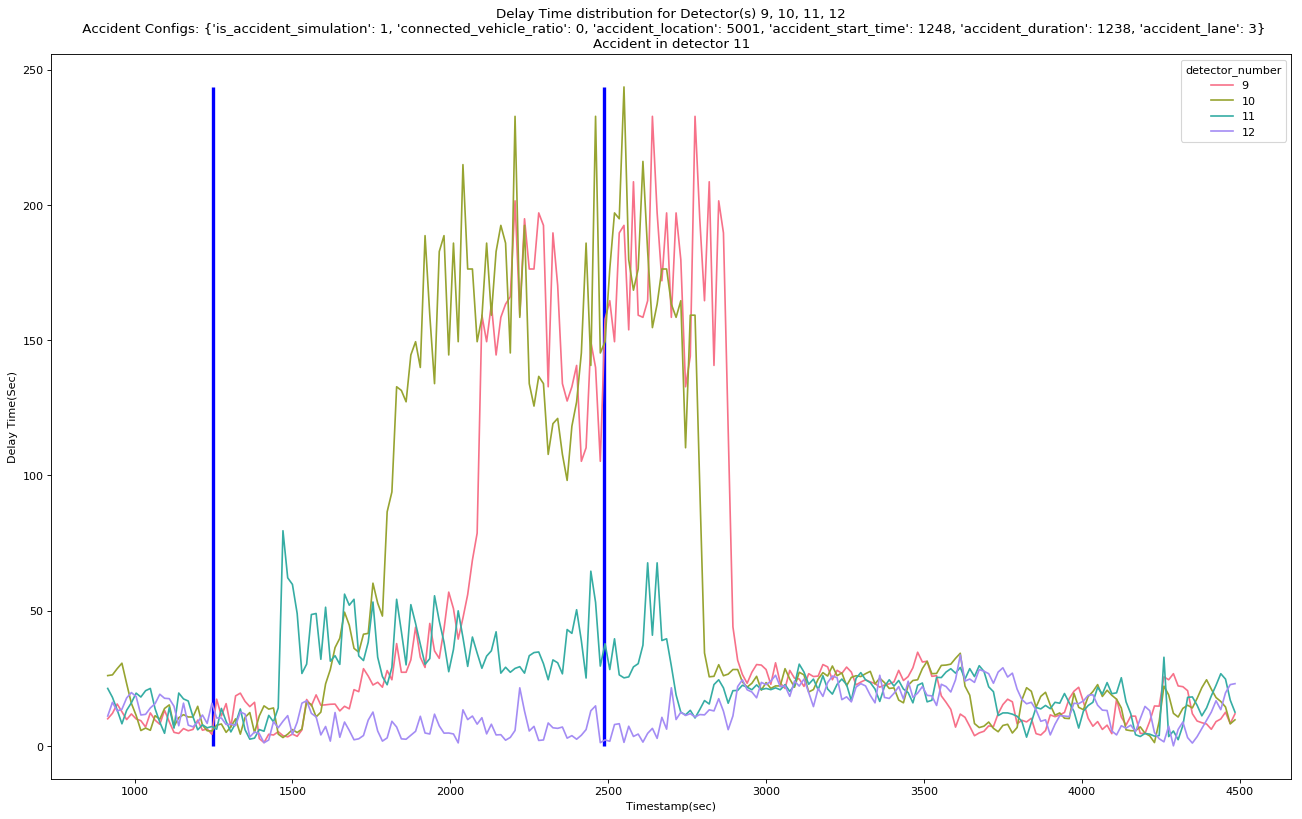

Function 'plot_detector_timelines' executed in 0.6439 seconds (0.01 minutes)


In [12]:
simulation_configs = {
    "is_accident_simulation" : 1,
    "connected_vehicle_ratio": 0,
    "accident_location" : 5001,
    "accident_start_time" : 1248,
    "accident_duration" : 1238,
    "accident_lane" : 3,
}
detector_numbers = [9,10,11,12]
plot_detector_timelines(df=df,detector_metric="delay_time_sec",detector_numbers=detector_numbers,simulation_configs=simulation_configs)

In [ ]:
plot_detector_timelines(df=df,detector_metric="flow_vehph",detector_numbers=detector_numbers,simulation_configs=simulation_configs)

In [ ]:
plot_detector_timelines(df=df,detector_metric="avg_speed_kmph",detector_numbers=detector_numbers,simulation_configs=simulation_configs)

In [ ]:
plot_detector_timelines(df=df,detector_metric="density_vehpkm",detector_numbers=detector_numbers,simulation_configs=simulation_configs)

### Remark
**Different accident lanes effect different road sections**<br>
Example:<br>
- Accident in detector 11-lane 3 affects detectors 9 & 10 more than 11 & 12
- Accident in detector 14-lane 1 affects detector 14 more than any other

## Feature Engineering

In [13]:
# Calculate lag values for flow_vehph, density_vehpkm, avg_speed_kmph, section_travel_time_sec & delay_time_sec
df = calculate_detector_lag_values(df,max_lag=10)
# Add features of previous & next detectors
df = calculate_adjacent_detector_features(df)
# Calculate time after accident
df["time_after_accident_started"] = df.apply(calculate_time_after_accident_start,axis=1)
# Calculate detector distance to incident
df["distance_to_accident"] = df.apply(calculate_distance_to_accident,axis=1)
# Calculate target (next time step) delay time
df["target_delay_time"] = calculate_target_value(df)

Function 'calculate_detector_lag_values' executed in 21.1125 seconds (0.35 minutes)
Function 'calculate_adjacent_detector_features' executed in 40.0662 seconds (0.67 minutes)
Function 'calculate_target_value' executed in 11.4985 seconds (0.19 minutes)


In [14]:
df.head()

,simulation_run,is_accident_simulation,connected_vehicle_ratio,accident_location,accident_start_time,accident_duration,accident_lane,timestamp,is_accident_timestamp,detector_number,...,prev_detector_section_travel_time_sec_lag9,prev_detector_delay_time_sec_lag9,prev_detector_flow_vehph_lag10,prev_detector_density_vehpkm_lag10,prev_detector_avg_speed_kmph_lag10,prev_detector_section_travel_time_sec_lag10,prev_detector_delay_time_sec_lag10,time_after_accident_started,distance_to_accident,target_delay_time
0,0,0,0.0,0,0,0,0,915,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9999999.0,11.776478
1,0,0,0.0,0,0,0,0,930,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9999999.0,18.261579
2,0,0,0.0,0,0,0,0,945,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9999999.0,25.441548
3,0,0,0.0,0,0,0,0,960,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9999999.0,15.226153
4,0,0,0.0,0,0,0,0,975,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,9999999.0,20.770317


In [15]:
#Check lagged features
simulation_timestamp_selector = (
            (df.simulation_run == 0)
            & (df.accident_location == 0)
            & (df.connected_vehicle_ratio == 0)
            & (df.accident_start_time == 0)
            & (df.accident_duration == 0)
            & (df.accident_lane == 0)
            & ((df.detector_number == 3))
        )
df[
 simulation_timestamp_selector   
].sort_values(["timestamp","detector_number"]).iloc[:9][["detector_number","timestamp","delay_time_sec","delay_time_sec_lag1","delay_time_sec_lag2","target_delay_time"]]

,detector_number,timestamp,delay_time_sec,delay_time_sec_lag1,delay_time_sec_lag2,target_delay_time
478,3,915,1.191800,NaN,NaN,1.897377
479,3,930,1.897377,1.191800,NaN,9.307293
480,3,945,9.307293,1.897377,1.191800,13.595625
481,3,960,13.595625,9.307293,1.897377,17.704857
482,3,975,17.704857,13.595625,9.307293,13.132452
483,3,990,13.132452,17.704857,13.595625,6.014435
484,3,1005,6.014435,13.132452,17.704857,7.215142
485,3,1020,7.215142,6.014435,13.132452,4.085635
486,3,1035,4.085635,7.215142,6.014435,16.542404


In [ ]:
#Check adjacent features
simulation_timestamp_selector = (
            (df.simulation_run == 0)
            & (df.connected_vehicle_ratio == 0)
            & (df.accident_location == 0)
            & (df.accident_start_time == 0)
            & (df.accident_duration == 0)
            & (df.accident_lane == 0)
            & ((df.detector_number == 2)| (df.detector_number == 3)  | (df.detector_number == 4))
        )
df[
 simulation_timestamp_selector   
].sort_values(["timestamp","detector_number"]).iloc[:9][["detector_number","timestamp","delay_time_sec","prev_detector_delay_time_sec","next_detector_delay_time_sec","delay_time_sec_lag1","next_detector_delay_time_sec_lag1","prev_detector_delay_time_sec_lag1"]]

In [ ]:
#All features
pprint(list(df.columns),width=200,compact=True)

In [16]:
df_na_columns = list(df.columns[df.isna().any()])

In [ ]:
df.isna().sum().sum() #5_243_055

In [36]:
%time
# Backfilling for NAs in lagged features
df_backfilled = df.copy()
df_backfilled.update(df.groupby(
    [
        "simulation_run",
        "connected_vehicle_ratio",
        "accident_location",
        "accident_start_time",
        "accident_duration",
        "accident_lane",
        "detector_number",
    ]
).fillna(method = "backfill"))

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 12.9 µs


In [37]:
df_backfilled_na_columns = list(df_backfilled.columns[df_backfilled.isna().any()])

In [38]:
set(df_na_columns).difference(set(df_backfilled_na_columns))

{'avg_speed_kmph_lag1',
 'avg_speed_kmph_lag10',
 'avg_speed_kmph_lag2',
 'avg_speed_kmph_lag3',
 'avg_speed_kmph_lag4',
 'avg_speed_kmph_lag5',
 'avg_speed_kmph_lag6',
 'avg_speed_kmph_lag7',
 'avg_speed_kmph_lag8',
 'avg_speed_kmph_lag9',
 'delay_time_sec_lag1',
 'delay_time_sec_lag3',
 'density_vehpkm_lag1',
 'density_vehpkm_lag10',
 'density_vehpkm_lag2',
 'density_vehpkm_lag3',
 'density_vehpkm_lag4',
 'density_vehpkm_lag5',
 'density_vehpkm_lag6',
 'density_vehpkm_lag7',
 'density_vehpkm_lag8',
 'density_vehpkm_lag9',
 'flow_vehph_lag1',
 'flow_vehph_lag10',
 'flow_vehph_lag2',
 'flow_vehph_lag3',
 'flow_vehph_lag4',
 'flow_vehph_lag5',
 'flow_vehph_lag6',
 'flow_vehph_lag7',
 'flow_vehph_lag8',
 'flow_vehph_lag9',
 'section_travel_time_sec_lag1',
 'section_travel_time_sec_lag3'}

In [39]:
df_backfilled.isna().sum().sum() #3_214_726

16073580

In [40]:
# Filling NAs in boundary detectors
column_list = list(df_backfilled.columns)
previous_detector_columns = []
next_detector_columns = []
current_detector_columns = []
for column_name in column_list:
    if "prev_detector_" in column_name:
        previous_detector_columns.append(column_name)
        original_column_name = column_name.replace("prev_detector_","")
        current_detector_columns.append(original_column_name)
        next_column_name = column_name.replace("prev_detector_","next_detector_")
        next_detector_columns.append(next_column_name)

df_backfilled_boundary_filled = df_backfilled.copy()
for previous_detector_column_name, current_detector_column_name in zip(previous_detector_columns, current_detector_columns):
    df_backfilled_boundary_filled[
        previous_detector_column_name
    ][
        (df_backfilled_boundary_filled.detector_number == 1)
    ] = df_backfilled_boundary_filled[current_detector_column_name][(df_backfilled_boundary_filled.detector_number == 1)]

for next_detector_column_name, current_detector_column_name in zip(next_detector_columns,current_detector_columns):
    df_backfilled_boundary_filled[
        next_detector_column_name
    ][
        (df_backfilled_boundary_filled.detector_number == 21)
    ] = df_backfilled_boundary_filled[current_detector_column_name][(df_backfilled_boundary_filled.detector_number == 21)]

# Drop last timestamps
df_backfilled_boundary_filled = df_backfilled_boundary_filled.dropna(subset=["target_delay_time"])

In [52]:
# Check for NAs
df_backfilled_boundary_filled = df_backfilled_boundary_filled.dropna()
df_backfilled_boundary_filled.isna().sum().sum() #0

0

In [54]:
df_final = df_backfilled_boundary_filled.copy()
feature_engineered_data_path = os.path.join(ROOT_DIRECTORY,"data/thesis_data/feature_engineered_data.csv")
df_final.to_csv(feature_engineered_data_path,index=False)